Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models. This tutorial introduces you to a complete ML workflow implemented in PyTorch covering all these steps.

# Submit a lab report containing codes, screenshots of output and tables for comparision of accuracies for both task 1 and task2 (for both datasets) with your name and registration number at the top.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import random

Check if GPU is available.

In [2]:
#check if gpu is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print ('<== CUDA availability : ==>', use_cuda)

<== CUDA availability : ==> True


Set seed for repreoducability.

In [3]:
#set seed for reproducability
def set_seeds(seed):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.determinictic = True
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
set_seeds(42)

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this lab, we will be using a TorchVision dataset. Load one of the prebuilt datasets from pytorch repository. Currently, we are not using any transform (manipulation) on input data. We are just converting each image to tensor.


In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Visualise some of the input images.

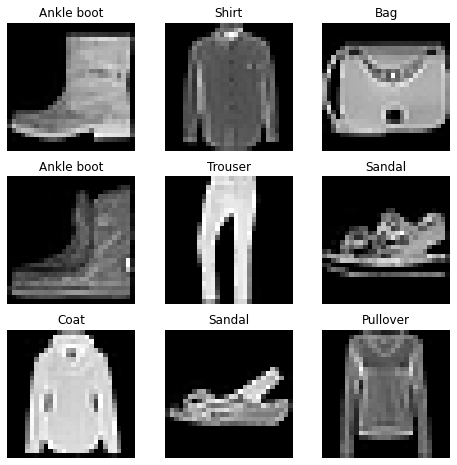

In [5]:
#Visualise some of the input images.
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()  # randomly pick indices from the training data
    img, label = training_data[sample_idx]                            # Read the images using their indices.
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Check the size and shape of training and validation data.

In [6]:
#Check the size and shape of training and validation data.
print ('Shape of Training Data', np.shape(training_data))
print ('Shape of Test Data', np.shape(test_data))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Shape of Training Data (60000, 2)
Shape of Test Data (10000, 2)


Now pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [8]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(   
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


# Q#1You may change the width of each layer from 128 to 256 and 512 and observe the difference in network performance. Also, try adding and removing layers. Keeping all other setup the same, how does the netowrk behave with the change in depth (number of layers) and width (size of each layer)?

Now define the loss function and set up optimiser.

In [9]:
#define the loss function and set up optimiser.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 

# Q#2: Try momentum with value 0.5 and 0.9. Try Adam optimizer instead of SGD (without momentum). How the learning process changes?

Define train function.

In [10]:
#Define train function.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)                        
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()             
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

Define evaluation function.

In [11]:
#Define evaluation function.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count. 
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")
    
    return test_loss

Initiate Training Process

In [ ]:
#Initiate Training Process
epochs = 5 # (Try 5, 10 and 50 epoch and record values for average validation loss and accuracy)
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    
    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1
-------------------------------
test loss: 
Accuracy: 33.1%, avg loss: 2.197754 

Epoch 2
-------------------------------


In [ ]:
model = model.to('cpu')
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Perform Inferrence

In [ ]:
#Perform Inferrence
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
#classes = np.array(test_data.class_to_idx.values())
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Q#3: Repeat all of above steps for Fashion MNIST dataset, apply question1 and 2 and report the accuracies.